# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size = 10, shuffle = True)
# Create test set and define test dataloader
## YOUR CODE HERE ##
test_set = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 10, shuffle = False)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Images and Labels Trainloader shapes
Images shapes:  torch.Size([10, 3, 32, 32])
Labels shapes:  torch.Size([10])

Images and labels Testloader shapes
Images shapes:  torch.Size([10, 3, 32, 32])
Labels shapes:  torch.Size([10])

The show5 Function: ---
truck


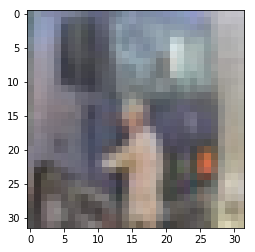

truck


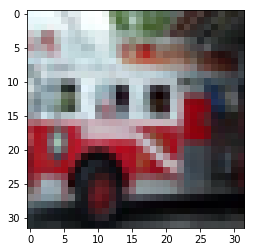

car


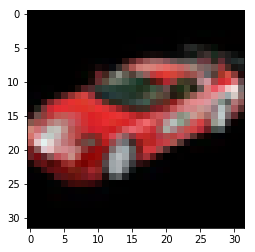

frog


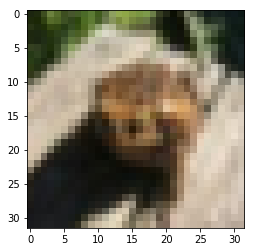

cat


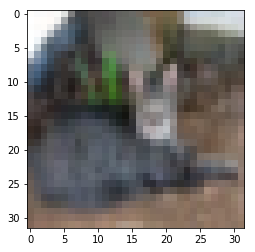

In [4]:
# Explore data
## YOUR CODE HERE ##
print('Images and Labels Trainloader shapes')
inp, feat = next(iter(trainloader))
print('Images shapes: ', inp.shape)
print('Labels shapes: ', feat.shape)
print('')
print('Images and labels Testloader shapes')
img, lab = next(iter(testloader))
print('Images shapes: ', img.shape)
print('Labels shapes: ', lab.shape)
print('')
print('The show5 Function: ---')
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
class My_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.batch = nn.BatchNorm2d(12)
        
        self.hl1 = nn.Linear(12*5*5, 200)
        self.hl2 = nn.Linear(200, 75)
        self.batchhl = nn.BatchNorm1d(75)
        self.output = nn.Linear(75, 10)

    def forward(self, x):
        
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.batch(self.conv2(x))))
        
        x = x.view(-1, 12*5*5)
        
        x = F.relu(self.hl1(x))
        x = F.relu(self.batchhl(self.hl2(x)))
        x = self.output(x)
        
        return x

### Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
Cifar_model = My_classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Cifar_model.parameters(), lr=0.008, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
## YOUR CODE HERE 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cifar_model.to(device)

train_losses, test_losses = [], []
epochs = 5
running_loss = 0
for e in range(epochs):
    for i, (images, labels) in enumerate(trainloader):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        log_ps = Cifar_model.forward(images)
        train_loss = criterion(log_ps, labels)
        train_loss.backward()
        optimizer.step()

        running_loss += train_loss.item()
        
    else:
        Cifar_model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, labels in testloader:
                
                images, labels = images.to(device), labels.to(device)
                
                log_ps = Cifar_model.forward(images)
                loss = criterion(log_ps, labels)
                
                test_loss += loss.item()
            
        t_l = running_loss/len(trainloader)
        train_losses.append(running_loss/len(trainloader))

        tt_l = test_loss/len(testloader)
        test_losses.append(test_loss/len(testloader))
        
        if i % 250 == 249:
            print('Epoch: {}/{}... '.format(e+1, i +1),
                  'Train loss: {:.4f}... '.format(t_l),
                  'Test Loss: {:.4f}... '.format(tt_l))
        running_loss = 0
        test_loss = 0
        Cifar_model.train()
        
print('Your Training Is Over!')

Epoch: 1/5000...  Train loss: 1.6371...  Test Loss: 1.4693... 
Epoch: 2/5000...  Train loss: 1.4174...  Test Loss: 1.4528... 
Epoch: 3/5000...  Train loss: 1.3308...  Test Loss: 1.2720... 
Epoch: 4/5000...  Train loss: 1.2731...  Test Loss: 1.1556... 
Epoch: 5/5000...  Train loss: 1.2296...  Test Loss: 1.1560... 
Your Training Is Over!


Plot the training loss (and validation loss/accuracy, if recorded).

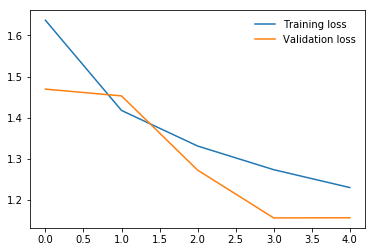

In [9]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
test_loss = 0
accuracy = 0
with torch.no_grad():
    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)

        log_ps = Cifar_model.forward(images)
        loss = criterion(log_ps, labels)

        test_loss += loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()       
    print('The Accuracy is: {:.2f}%'.format(accuracy/len(testloader)*100))

The Accuracy is: 56.38%


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
## YOUR CODE HERE ##
torch.save(Cifar_model.state_dict(), 'Cifar10.pth')

#Now I'll load and print the state dict.
state_d = torch.load('Cifar10.pth')
print(state_d.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'batch.weight', 'batch.bias', 'batch.running_mean', 'batch.running_var', 'hl1.weight', 'hl1.bias', 'hl2.weight', 'hl2.bias', 'batchhl.weight', 'batchhl.bias', 'batchhl.running_mean', 'batchhl.running_var', 'output.weight', 'output.bias'])


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

### My Recommendation: 

Based on my assessment, my recommendation is that we can build the model.

My model is actually very simple and there is a lot of difference with Detectocorp, I still have to learn more things, with this project I investigated a lot and learned new things that I had not been able to see in the classes, but I think that by having more experience I can build a better model.

And comparing it with the literature solutions, in my opinion I have a long way to go to improve it, and to improve myself.

The precision was achieved by improving my model, for example, I had only implemented nn.Linear at the beginning and it had a very low accuracy, I investigated how nn.Conv2d, nn.MaxPool2d and nn.BatchNorm2d / 1d work, I implemented them as I could, and Then I only improved the inputs and outputs of these parameters, I implemented optim.Adam () first, but then I decided to test with optim.SGD () and test my (learning rate and momentum) until I achieved better accuracy, I also played a bit with the batchsize in the dataloader.

Actually I think it is very necessary to improve this evaluation, I think that improving my Neural Network would be a very important point, making this a larger and more precise Neural Network, also testing the learning rate and the type of loss function and optimizer that we could use.

In my opinion, I think that I need a lot of experience to compare myself with Detectocorp, or with the other solutions, it seemed like an excellent project, I have spent many hours trying to understand the errors that appeared to me, what else to implement in my neural network, and how improve my accuracy, I have learned a lot since I finished classes and started the project until I finished it.

In conclusion I recommend building the model, I think it is a bit challenging to achieve a very high accuracy, but I do not think it is impossible, we should only look for more information to improve, feel like doing it and not give up.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).